In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
import librosa.display
from IPython.display import Audio

import torchaudio
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import Wav2Vec2Model, Wav2Vec2Processor, Trainer, TrainingArguments, Wav2Vec2ForSequenceClassification, Wav2Vec2Config

import warnings
warnings.filterwarnings('ignore')


In [ ]:
!kaggle datasets download ejlok1/toronto-emotional-speech-set-tess

Dataset URL: https://www.kaggle.com/datasets/ejlok1/toronto-emotional-speech-set-tess
License(s): Attribution-NonCommercial-NoDerivatives 4.0 International (CC BY-NC-ND 4.0)
100% 426M/428M [00:20<00:00, 23.0MB/s]
100% 428M/428M [00:20<00:00, 22.0MB/s]


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/toronto-emotional-speech-set-tess.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
paths = []
labels = []
for dirname, _, filenames in os.walk('/content/tess toronto emotional speech set data/'):
    for filename in filenames:
        paths.append(os.path.join(dirname, filename))
        label = filename.split('_')[-1]
        label = label.split('.')[0]
        labels.append(label.lower())
    if len(paths) == 2800:
        break
print("Dataset is loaded")

Dataset is loaded


In [ ]:
len(paths)

2800

In [ ]:
paths[:5]

['/content/tess toronto emotional speech set data/TESS Toronto emotional speech set data/YAF_pleasant_surprised/YAF_third_ps.wav',
 '/content/tess toronto emotional speech set data/TESS Toronto emotional speech set data/YAF_pleasant_surprised/YAF_shirt_ps.wav',
 '/content/tess toronto emotional speech set data/TESS Toronto emotional speech set data/YAF_pleasant_surprised/YAF_check_ps.wav',
 '/content/tess toronto emotional speech set data/TESS Toronto emotional speech set data/YAF_pleasant_surprised/YAF_thumb_ps.wav',
 '/content/tess toronto emotional speech set data/TESS Toronto emotional speech set data/YAF_pleasant_surprised/YAF_near_ps.wav']

In [ ]:
labels[:5]

['ps', 'ps', 'ps', 'ps', 'ps']

In [ ]:
#create a dataframe
df = pd.DataFrame()
df['speech'] = paths
df['label'] = labels
df.head()

,speech,label
0,/content/tess toronto emotional speech set dat...,ps
1,/content/tess toronto emotional speech set dat...,ps
2,/content/tess toronto emotional speech set dat...,ps
3,/content/tess toronto emotional speech set dat...,ps
4,/content/tess toronto emotional speech set dat...,ps


In [ ]:
df['label'].value_counts()

,count
label,
ps,400
fear,400
neutral,400
angry,400
disgust,400
sad,400
happy,400


## Exploratory Data Analysis

<Axes: xlabel='count', ylabel='label'>

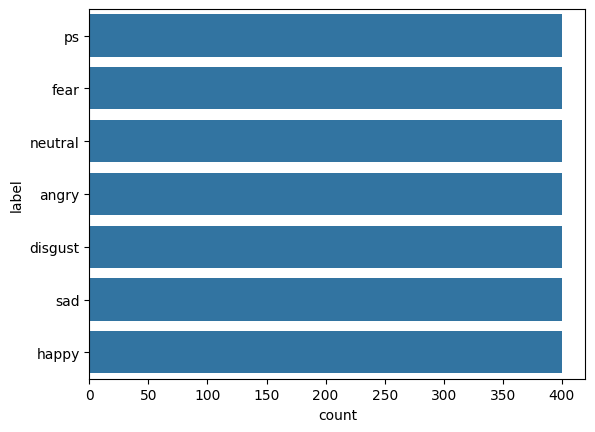

In [ ]:
sns.countplot(df['label'])

In [ ]:
def waveplot(data, sr, emotion):
  plt.figure(figsize=(10,4))
  plt.title(emotion, size=20)
  librosa.display.waveshow(data, sr=sr)
  plt.show()

def spectogram(data, sr, emotion):
  x = librosa.stft(data)
  xdb = librosa.amplitude_to_db(abs(x))
  plt.figure(figsize=(11,4))
  plt.title(emotion, size=20)
  librosa.display.specshow(xdb, sr=sr, x_axis='time', y_axis='hz')
  plt.colorbar()

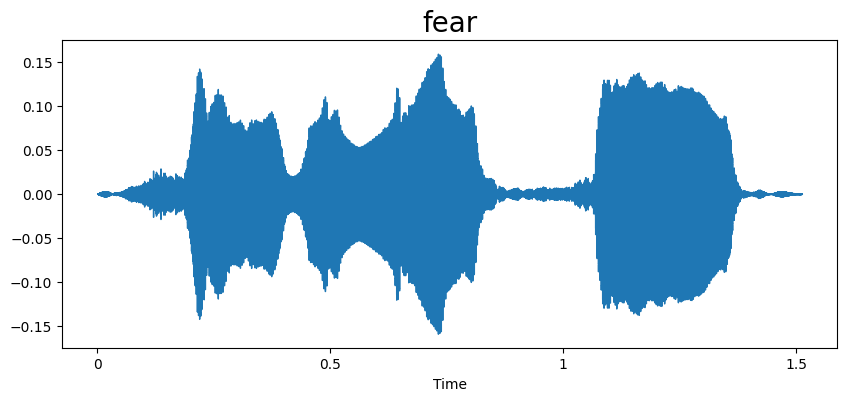

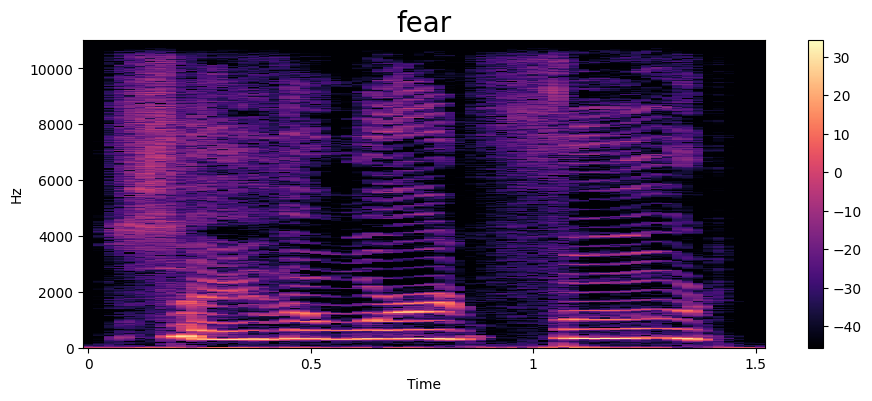

In [ ]:
emotion = 'fear'
path = np.array(df['speech'][df['label']==emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

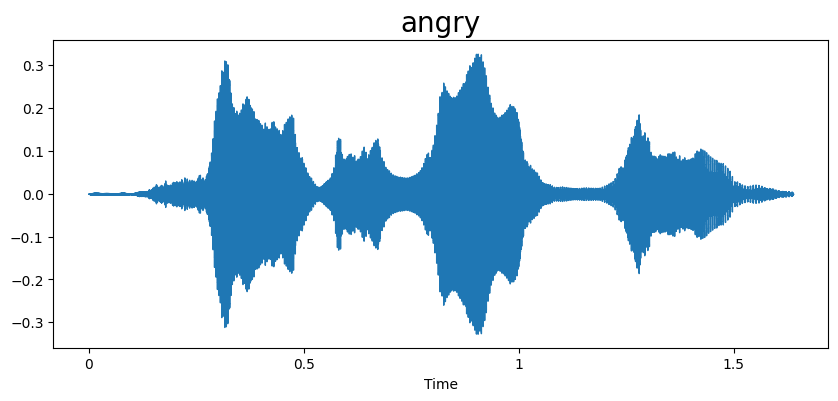

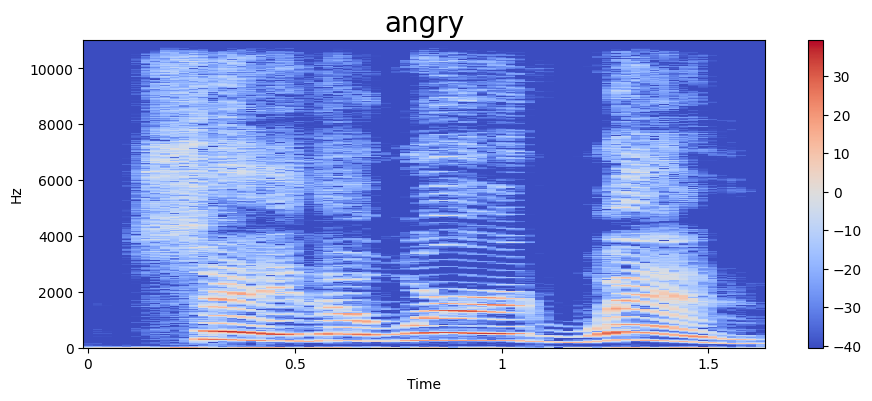

In [ ]:
emotion = 'angry'
path = np.array(df['speech'][df['label']==emotion])[1]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

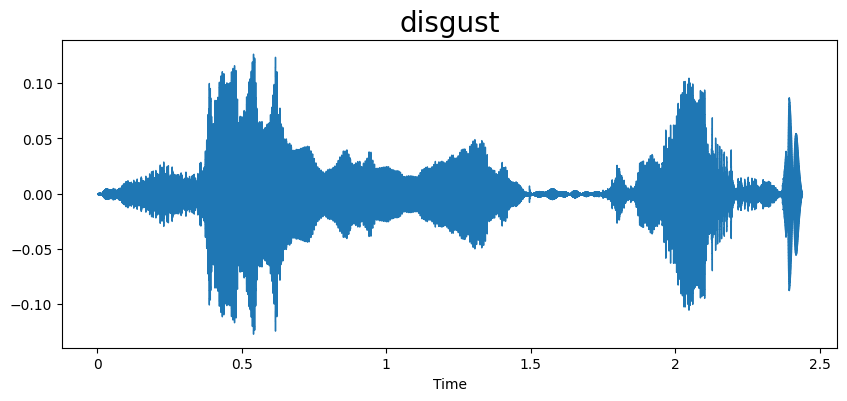

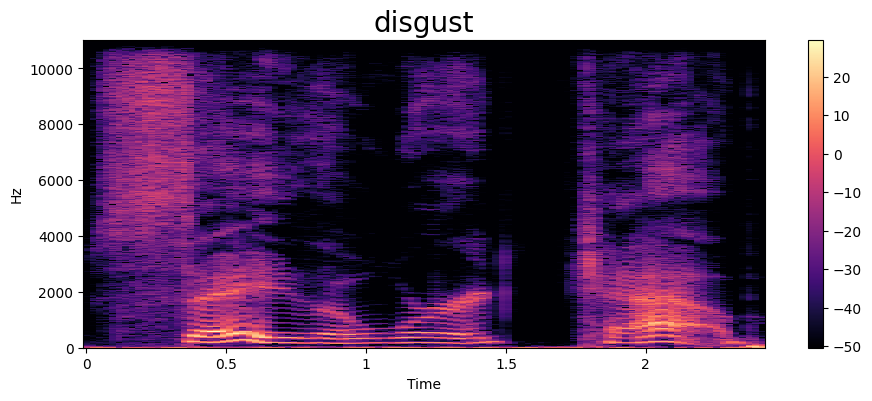

In [ ]:
emotion = 'disgust'
path = np.array(df['speech'][df['label']==emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

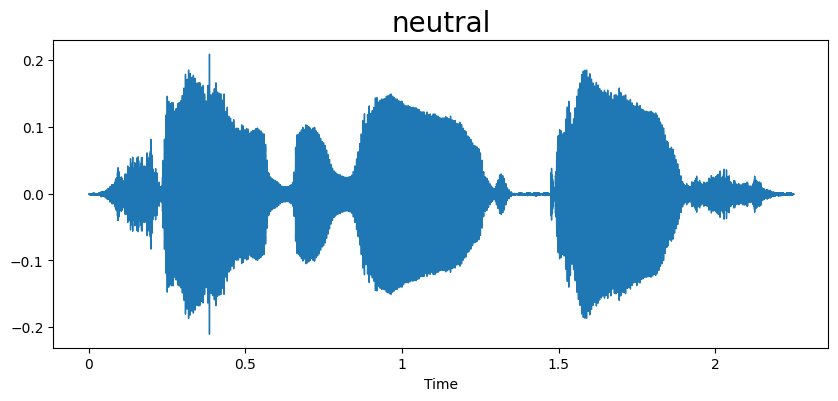

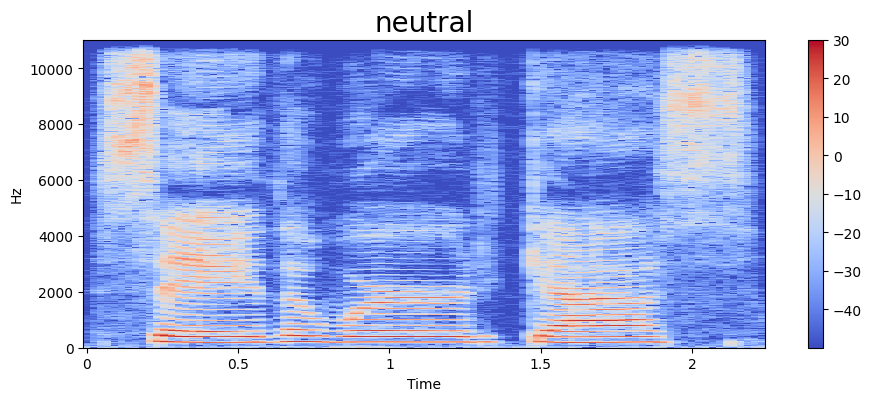

In [ ]:
emotion = 'neutral'
path = np.array(df['speech'][df['label']==emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

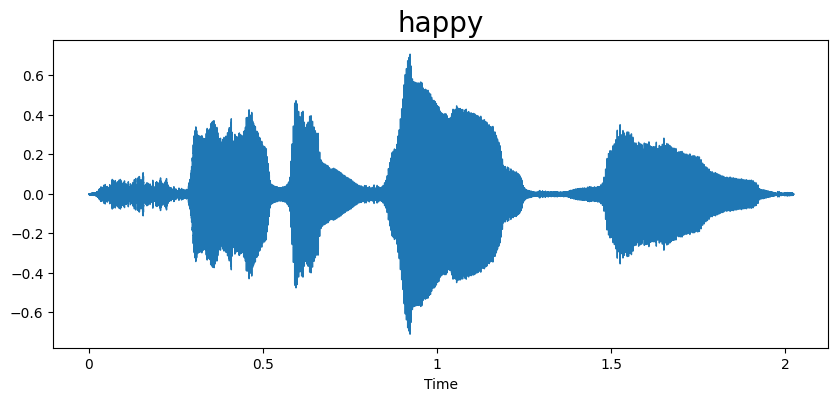

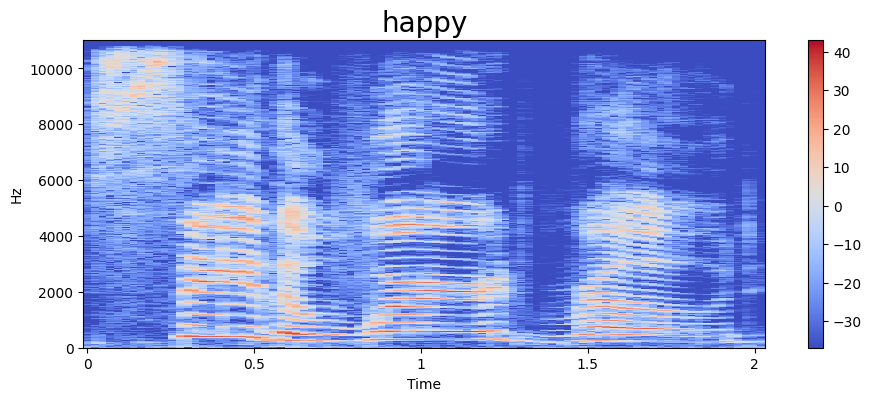

In [ ]:
emotion = 'happy'
path = np.array(df['speech'][df['label']==emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

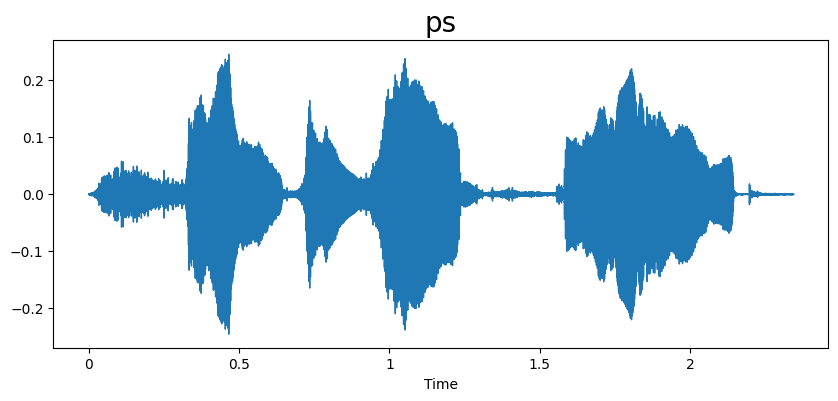

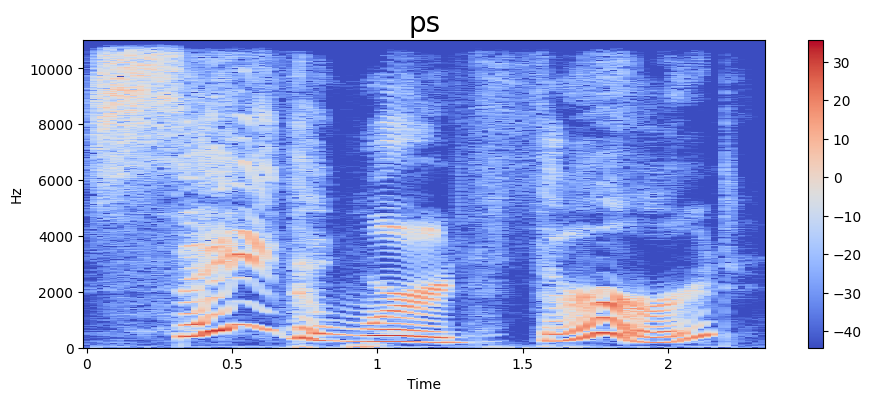

In [ ]:
emotion = 'ps'
path = np.array(df['speech'][df['label']==emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

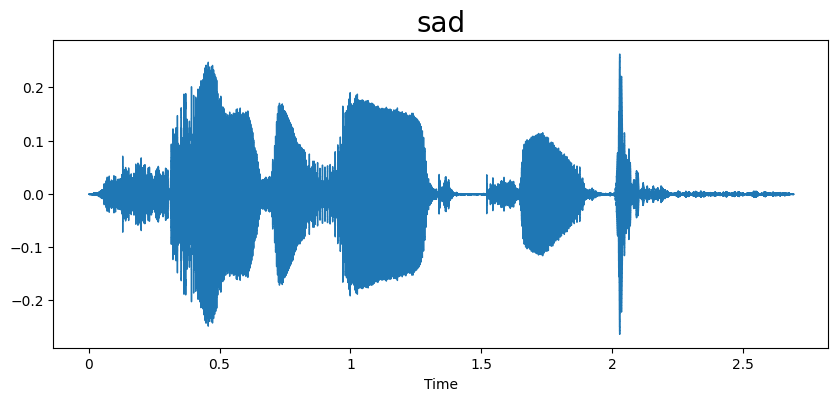

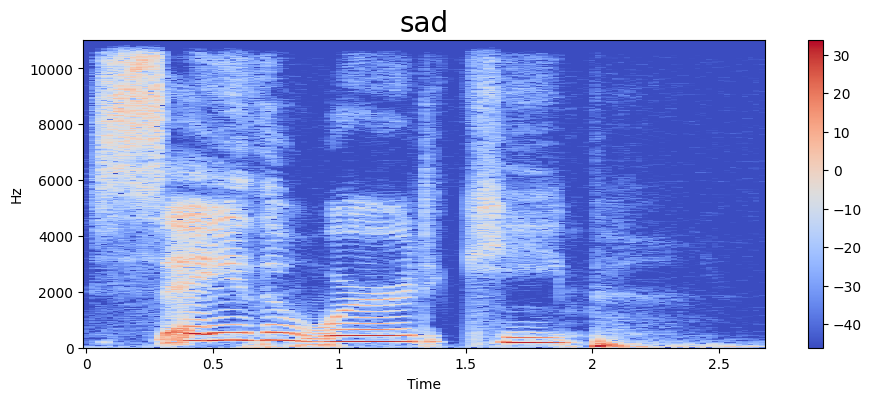

In [ ]:
emotion = 'sad'
path = np.array(df['speech'][df['label']==emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

## create custom dataaset class

In [ ]:
#convert label to integers
label_map = {label: idx for idx, label in enumerate(df['label'].unique())}
inverse_label_map = {idx: label for label, idx in label_map.items()}
df['label'] = df['label'].map(label_map)
df.head()

,speech,label
0,/content/tess toronto emotional speech set dat...,0
1,/content/tess toronto emotional speech set dat...,0
2,/content/tess toronto emotional speech set dat...,0
3,/content/tess toronto emotional speech set dat...,0
4,/content/tess toronto emotional speech set dat...,0


In [ ]:
class speechEmotionDataset(Dataset):
  def __init__(self, df, processor, max_length=32000):
    self.df = df
    self.processor = processor
    self.max_length = max_length

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    audio_path = self.df.iloc[idx, 0]
    label = self.df.iloc[idx, 1]

    #load the audio file
    speech, sr = librosa.load(audio_path, sr=16000)


    #pad or truncate the speech to the required length
    if len(speech) > self.max_length:
      speech = speech[:self.max_length]
    else:
      speech = np.pad(speech, (0, self.max_length - len(speech)), mode='constant')

    # preprocess the audio file
    inputs = self.processor(speech, sampling_rate=16000, return_tensors='pt', padding=True, truncation=True, max_length=self.max_length)

    input_values = inputs.input_values.squeeze()
    return {'input_values': input_values, 'label': torch.tensor(label, dtype=torch.long)}

In [ ]:
#split the data from train and test
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

In [ ]:
# initialize the processor AND MODEL
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base")
# Create a configuration with dropout
config = Wav2Vec2Config.from_pretrained("facebook/wav2vec2-base", num_labels=len(label_map), hidden_dropout=0.2, attention_probs_dropout_prob=0.2)

# Create the model with the modified configuration
model = Wav2Vec2ForSequenceClassification(config)

In [ ]:
#load the datset
train_dataset = speechEmotionDataset(train_df, processor)
test_dataset = speechEmotionDataset(test_df, processor)

#set training arguments


In [ ]:
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy='epoch',
    save_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    warmup_steps=500,
    weight_decay=0.01,
    report_to = []
)

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

In [ ]:
def compute_metrics(pred):
  labels = pred.label_ids # original labels
  preds = np.argmax(pred.predictions, axis=1) # model predicted labels
  accuracy = accuracy_score(labels, preds)
  precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
  return {
      'accuracy': accuracy,
      'precision': precision,
      'recall': recall,
      'f1': f1
  }

In [ ]:
# initialize trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.996705,0.573214,0.549980,0.573214,0.535548
2,1.320200,0.497534,0.800000,0.871179,0.800000,0.769810
3,1.320200,0.191799,0.953571,0.954213,0.953571,0.953322


TrainOutput(global_step=840, training_loss=0.9787476312546503, metrics={'train_runtime': 390.0, 'train_samples_per_second': 17.231, 'train_steps_per_second': 2.154, 'total_flos': 1.2201848064e+17, 'train_loss': 0.9787476312546503, 'epoch': 3.0})

In [ ]:
results = trainer.evaluate()
print(results)

{'eval_loss': 0.19179916381835938, 'eval_accuracy': 0.9535714285714286, 'eval_precision': 0.9542126756710345, 'eval_recall': 0.9535714285714286, 'eval_f1': 0.9533220349078461, 'eval_runtime': 6.286, 'eval_samples_per_second': 89.087, 'eval_steps_per_second': 11.136, 'epoch': 3.0}


## Test predictions

In [ ]:
import random
idx = random.randrange(0, len(test_dataset))
print("Original Label:", inverse_label_map[int(test_dataset[idx]['label'])])
input_values = test_dataset[idx]['input_values'].unsqueeze(0).to('cuda')

with torch.no_grad():
  outputs = model(input_values)
logits = outputs.logits

predicted_class = logits.argmax(dim=-1).item()
print("Predicted Class:", inverse_label_map[predicted_class])


Original Label: angry
Predicted Class: angry


In [ ]:
import random
idx = random.randrange(0, len(test_dataset))
print("Original Label:", inverse_label_map[int(test_dataset[idx]['label'])])
input_values = test_dataset[idx]['input_values'].unsqueeze(0).to('cuda')

with torch.no_grad():
  outputs = model(input_values)
logits = outputs.logits

predicted_class = logits.argmax(dim=-1).item()
print("Predicted Class:", inverse_label_map[predicted_class])


Original Label: neutral
Predicted Class: neutral


In [ ]:

import random
idx = random.randrange(0, len(test_dataset))
print("Original Label:", inverse_label_map[int(test_dataset[idx]['label'])])
input_values = test_dataset[idx]['input_values'].unsqueeze(0).to('cuda')

with torch.no_grad():
  outputs = model(input_values)
logits = outputs.logits

predicted_class = logits.argmax(dim=-1).item()
print("Predicted Class:", inverse_label_map[predicted_class])


Original Label: angry
Predicted Class: angry


In [ ]:
# prompt: i want to test this model by giving my own audio as input. the inputed audio then goes through the  speechEmotionDataset class and then unsqueeze and show the output

import librosa
import torch

# Assuming 'processor' and 'model' are defined from the previous code
# and are loaded with the trained weights

def predict_emotion(audio_file_path):
    speech, sr = librosa.load(audio_file_path, sr=16000)
    # Preprocess the audio
    inputs = processor(speech, sampling_rate=16000, return_tensors='pt', padding=True, truncation=True, max_length=32000)
    input_values = inputs.input_values.squeeze(0).to('cuda')  # Move to CUDA if available

    # Make the prediction
    with torch.no_grad():
        outputs = model(input_values.unsqueeze(0)) # Add an extra dimension for batch
        logits = outputs.logits

    predicted_class = logits.argmax(dim=-1).item()
    return inverse_label_map[predicted_class]

# Example usage:
# Upload an audio file to your Colab environment or provide the path to a local file
# Replace 'your_audio_file.wav' with the actual path
audio_file = 'happy.wav' #@param {type:"string"}

predicted_emotion = predict_emotion(audio_file)
print(f"Predicted emotion for {audio_file}: {predicted_emotion}")

Predicted emotion for happy.wav: neutral


In [ ]:
from google.colab import drive
drive.mount('/content/drive')